### Постановка учебной бизнес-задачи
Проанализировать данные о торговых точках Старбакс в Москве и выделить кластер наименнее эффективных точек. Оценить влияние на выручку, маржинальность и удовлетворенность клиентов для закрытия неэффективного кластера.


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, cluster
import scipy

import folium
import geopy

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

### Загрузка и предобработка данных

In [93]:
df = pd.read_csv('Starbucks.csv')
df.head(2)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42


In [94]:
del df['State/Province']
del df['Postcode']
del df['Phone Number']
del df['Store Name']

In [95]:
df.head(2)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,Licensed,"Av. Meritxell, 96",Andorra la Vella,AD,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Licensed,"1 Street 69, Al Jarf",Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.42


Можно определить столбец "Store Number" в качестве индекса, но для этого нужно проверить наличие дублей.

In [96]:
df['Store Number'].value_counts().sort_values(ascending=False) #сортируем по убыванию и видим один повтор

19773-160973    2
74263-51682     1
31412-107164    1
4941-104025     1
32145-133166    1
               ..
17932-186985    1
79471-90340     1
75794-91842     1
14816-131984    1
76486-93022     1
Name: Store Number, Length: 25599, dtype: int64

In [97]:
df.loc[df['Store Number'] == '19773-160973'] #сортировка по значению выбранного столбца

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
8028,Starbucks,19773-160973,Joint Venture,"23 & 23-1, Yoido-Dong, Yongdongpo-Gu, 1F, #101",Seoul,KR,GMT+09:00 Asia/Seoul,NaN,NaN
8159,Starbucks,19773-160973,Joint Venture,"23 & 23-1, Yoido-Dong, Yongdongpo-Gu, 1F, #101",Seoul,KR,GMT+09:00 Asia/Seoul,126.92,37.53


Выделяем номер строки, которую необходимо удалить:

In [98]:
#np.where(df['Store Number'] == "19773-160973") and np.where(pd.isna(df['Longitude']) == True)[0]

np.where(df['Store Number'] == '19773-160973') #получаем массив со значениями строк

(array([8028, 8159]),)

In [99]:
pd.isna(df['Longitude'])

0        False
1        False
2        False
3        False
4        False
         ...  
25595    False
25596    False
25597    False
25598    False
25599    False
Name: Longitude, Length: 25600, dtype: bool

In [100]:
np.where(pd.isna(df['Longitude']) == True)[0] # единственный пропуск во всем датасете в столбце "Longitude", иначе бы получили несколько значений строк в массиве


array([8028])

In [101]:
np.where(df['Store Number'] == '19773-160973') and np.where(pd.isna(df['Longitude']) == True)[0]

array([8028])

In [102]:
df = df.drop(np.where(df['Store Number'] == '19773-160973') and np.where(pd.isna(df['Longitude']) == True)[0])

In [103]:
df['Store Number'].value_counts().sort_values(ascending=False)

25924-241625    1
28054-247306    1
35032-92141     1
31412-107164    1
4941-104025     1
               ..
28232-250138    1
17932-186985    1
79471-90340     1
75794-91842     1
76486-93022     1
Name: Store Number, Length: 25599, dtype: int64

In [104]:
df.set_index(df['Store Number'], inplace=True)

In [105]:
df.head(2)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
Store Number,,,,,,,,,
47370-257954,Starbucks,47370-257954,Licensed,"Av. Meritxell, 96",Andorra la Vella,AD,GMT+1:00 Europe/Andorra,1.53,42.51
22331-212325,Starbucks,22331-212325,Licensed,"1 Street 69, Al Jarf",Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.42


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25599 entries, 47370-257954 to 47609-253286
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           25599 non-null  object 
 1   Store Number    25599 non-null  object 
 2   Ownership Type  25599 non-null  object 
 3   Street Address  25597 non-null  object 
 4   City            25584 non-null  object 
 5   Country         25599 non-null  object 
 6   Timezone        25599 non-null  object 
 7   Longitude       25599 non-null  float64
 8   Latitude        25599 non-null  float64
dtypes: float64(2), object(7)
memory usage: 2.0+ MB


In [107]:
df.loc[pd.isna(df['Street Address']) == True]

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
Store Number,,,,,,,,,
30997-103902,Starbucks,30997-103902,Joint Venture,NaN,부산,KR,GMT+09:00 Asia/Seoul,129.15,35.16
1329-152826,Starbucks,1329-152826,Joint Venture,NaN,광주,KR,GMT+09:00 Asia/Seoul,126.91,35.15


In [108]:
df.loc[pd.isna(df['City']) == True]

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
Store Number,,,,,,,,,
31657-104436,Starbucks,31657-104436,Licensed,طريق الكورنيش أبراج سان ستيفانو,NaN,EG,GMT+2:00 Africa/Cairo,29.96,31.24
32152-109504,Starbucks,32152-109504,Licensed,كورنيش النيل أبراج النايل سيتى,NaN,EG,GMT+2:00 Africa/Cairo,31.23,30.07
32314-115172,Starbucks,32314-115172,Licensed,"الكيلو 28 طريق الاسكندرية الصحراوى, سيتى سنتر ...",NaN,EG,GMT+2:00 Africa/Cairo,31.03,30.06
31479-105246,Starbucks,31479-105246,Licensed,"شارع مكرم عبيد, سيتى ستارز مول",NaN,EG,GMT+2:00 Africa/Cairo,31.34,30.09
31756-107161,Starbucks,31756-107161,Licensed,"شارع عمر بن الخطاب, سيتى ستارز مول",NaN,EG,GMT+2:00 Africa/Cairo,31.33,30.06
1397-139244,Starbucks,1397-139244,Licensed,"شارع عمر بن الخطاب, كارفور المعادى",NaN,EG,GMT+2:00 Africa/Cairo,31.33,30.06
32191-116645,Starbucks,32191-116645,Licensed,القطامية الطريق الدائرى,NaN,EG,GMT+2:00 Africa/Cairo,31.30,29.99
3664-142484,Starbucks,3664-142484,Licensed,"34شارع سليمان أباظة المهندسين, تيفولى مول",NaN,EG,GMT+2:00 Africa/Cairo,31.20,30.06
3562-131562,Starbucks,3562-131562,Licensed,"ألماظة ميدان الجوهر شارع أحمد فوزى, صالة السفر 1",NaN,EG,GMT+2:00 Africa/Cairo,31.34,30.08


In [109]:
df.fillna('No_data', inplace=True) #заполняем пропуски на строку "No_data"

### EDA

In [110]:
import sweetviz as sv

In [111]:
feature_config = sv.FeatureConfig(skip=["Store Number", "Street Address"])

In [112]:
report = sv.analyze(df, feat_cfg = feature_config)  #получаем отчет по признакам датасета, автоматически сохраняется в jupyter-notebook

report.show_html('Lesson_5_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Lesson_5_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Добавление показателей эффективности кофеен

Генерируем случайным образом значения (в данном датасете их нет, коммерческая тайна): Revenue(доход), Cost(затраты на объект), Satisfaction(удовлетворенность покупателей)

In [113]:
df['Revenue'] = np.random.randint(low=150000, high=250000, size=len(df), )
df['Cost'] = np.random.randint(low=120000, high=210000, size= len(df))
df['Satisfaction'] = np.random.choice(['Very_satisfied', 'Satisfied', 'Neither', 'Dissatisfied', 'Very_dissatisfied'], size= len(df), p=[0.4, 0.4, 0.1, 0.07, 0.03])
#p - это вероятность встречаемости ответа

In [114]:
df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction
Store Number,,,,,,,,,,,,
47370-257954,Starbucks,47370-257954,Licensed,"Av. Meritxell, 96",Andorra la Vella,AD,GMT+1:00 Europe/Andorra,1.53,42.51,159232,176199,Very_satisfied
22331-212325,Starbucks,22331-212325,Licensed,"1 Street 69, Al Jarf",Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.42,214582,144679,Very_satisfied
47089-256771,Starbucks,47089-256771,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.39,206801,135259,Very_satisfied


In [115]:
city = 'Moscow'

locator = geopy.geocoders.Nominatim(user_agent='Lesson_5')
location = locator.geocode(city)
location = [location.latitude, location.longitude]

In [116]:
Moscow_df = df.loc[df['City'] == 'Moscow'] #создаем новый датафрейм по Москве

In [117]:
Moscow_df["Country"].value_counts()

RU    74
US     3
Name: Country, dtype: int64

In [118]:
Moscow_df.loc[Moscow_df['Country'] == 'US']

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction
Store Number,,,,,,,,,,,,
79663-115245,Starbucks,79663-115245,Licensed,1320 Blaine St,Moscow,US,GMT-08:00 America/Los_Angeles,-116.98,46.72,204124,122252,Neither
3760-126584,Starbucks,3760-126584,Licensed,710 S Deakin St,Moscow,US,GMT-08:00 America/Los_Angeles,-117.01,46.73,233452,120057,Satisfied
3357-166484,Starbucks,3357-166484,Company Owned,1930 West Pullman Road,Moscow,US,GMT-08:00 America/Los_Angeles,-117.03,46.73,181974,122978,Very_satisfied


In [119]:
Moscow_df = Moscow_df.loc[Moscow_df['Country'] == 'RU']

In [120]:
Moscow_df['Country'].value_counts()

RU    74
Name: Country, dtype: int64

In [121]:
Moscow_map = folium.Map(location=location, zoom_start=10)

In [122]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15)) #инициализация скейлера, нужен чтобы отразить размер прибыли торговой точки
Moscow_df['size'] = scaler.fit_transform(Moscow_df['Revenue'].values.reshape(-1, 1)).reshape(-1)

for index, row in Moscow_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    
    if row['Revenue'] < row['Cost']:
        current_color = 'red'
    else:
        current_color = 'green'
    
    folium.CircleMarker(location=current_location, fill=True, color=current_color, radius = row['size']).add_to(Moscow_map)

In [123]:
Moscow_map

In [124]:
Moscow_df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction,size
Store Number,,,,,,,,,,,,,
18904-138404,Starbucks,18904-138404,Joint Venture,"Timura Frunze St 11, Khamovniki District",Moscow,RU,GMT+3:00 Europe/Moscow,37.59,55.73,185262,200068,Very_satisfied,7.254138
1562-152965,Starbucks,1562-152965,Joint Venture,"Verkhnaya Krasnosel'skaya street 3A, Baumansky 61",Moscow,RU,GMT+3:00 Europe/Moscow,37.67,55.78,220892,186842,Satisfied,11.617262
3011-138431,Starbucks,3011-138431,Joint Venture,"Presnenskaya nab., 2, Ground Floor",Moscow,RU,GMT+3:00 Europe/Moscow,37.54,55.75,238169,162261,Satisfied,13.732943


In [125]:
Moscow_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 18904-138404 to 23423-230244
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74 non-null     object 
 1   Store Number    74 non-null     object 
 2   Ownership Type  74 non-null     object 
 3   Street Address  74 non-null     object 
 4   City            74 non-null     object 
 5   Country         74 non-null     object 
 6   Timezone        74 non-null     object 
 7   Longitude       74 non-null     float64
 8   Latitude        74 non-null     float64
 9   Revenue         74 non-null     int64  
 10  Cost            74 non-null     int64  
 11  Satisfaction    74 non-null     object 
 12  size            74 non-null     float64
dtypes: float64(3), int64(2), object(8)
memory usage: 8.1+ KB


In [126]:
Moscow_df['Satisfaction'].value_counts()

Very_satisfied       40
Satisfied            15
Neither              11
Dissatisfied          7
Very_dissatisfied     1
Name: Satisfaction, dtype: int64

### Кластеризация

Добавим новые признаки:

In [127]:
Moscow_df['Profit'] = Moscow_df['Revenue'] - Moscow_df['Cost']
Moscow_df['Satisfaction'] = Moscow_df['Satisfaction'].map({"Very_satisfied": 10, "Satisfied":6, "Neither" : 4, "Dissatisfied": 2, "Very_dissatisfied": 1})

X = Moscow_df[["Satisfaction","Profit"]]
X

,Satisfaction,Profit
Store Number,,
18904-138404,10,-14806
1562-152965,6,34050
3011-138431,6,75908
16776-175645,10,14285
32451-119274,10,-13565
...,...,...
15810-164487,10,67885
6161-149846,10,-10798
3627-115109,10,41761


In [128]:
max_k = 10  # подбираем оптимальное количество кластеров, задаем максимальное их число

In [129]:
distortions = []
for i in range(1, (max_k+1)): 
    if len(X) >= i: #количество объектов должно быть больше числа кластеров
        model = KMeans(n_clusters=i, max_iter=300, n_init=10)
        model.fit(X)
        distortions.append(model.inertia_) #метрика
    

k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)])) #формула расчета оптимального количества кластеров ELBOW
k

7

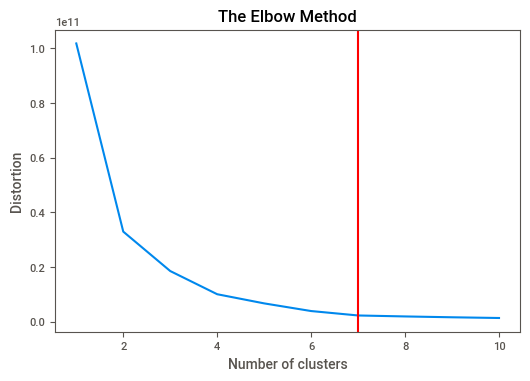

In [130]:
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='-', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")

plt.show()

Получаем, что в нашем случае оптимальное количество кластеров равно 7.

In [133]:
k=7
model = KMeans(n_clusters=k)

X = Moscow_df[['Satisfaction', 'Profit']]
Moscow_df['cluster'] = model.fit_predict(X) #в новый столбец положим значение прогноза модели

In [134]:
Moscow_df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction,size,Profit,cluster
Store Number,,,,,,,,,,,,,,,
18904-138404,Starbucks,18904-138404,Joint Venture,"Timura Frunze St 11, Khamovniki District",Moscow,RU,GMT+3:00 Europe/Moscow,37.59,55.73,185262,200068,10,7.254138,-14806,4
1562-152965,Starbucks,1562-152965,Joint Venture,"Verkhnaya Krasnosel'skaya street 3A, Baumansky 61",Moscow,RU,GMT+3:00 Europe/Moscow,37.67,55.78,220892,186842,6,11.617262,34050,0
3011-138431,Starbucks,3011-138431,Joint Venture,"Presnenskaya nab., 2, Ground Floor",Moscow,RU,GMT+3:00 Europe/Moscow,37.54,55.75,238169,162261,6,13.732943,75908,2


In [136]:
new_moscow_map = folium.Map(location= location, zoom_start=10)

In [137]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
Moscow_df["size"] = scaler.fit_transform(Moscow_df["Revenue"].values.reshape(-1,1)).reshape(-1)
color_dict = {0: 'green', 1: "red", 2:"orange", 3:"blue", 4: "yellow", 5: "black", 6: "grey"}

for index, row in Moscow_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    current_color = color_dict[row['cluster']]
    folium.CircleMarker(location=current_location, fill=True, color = current_color , radius = row['size'] ).add_to(new_moscow_map)

In [138]:
new_moscow_map

Оценим средние значения прибыли, профита, уровня удовлетворенности по каждому кластеру:

In [139]:
columns = ["Cluster", "Average_Revenue", "Sum_Revenue", "Average_Profit", "Sum_Profit", "Average_Satisfaction"]
result_df = pd.DataFrame(columns = columns)
for i in set(Moscow_df['cluster']):
    cluster_df = Moscow_df.loc[Moscow_df['cluster'] == i]
    result_df.loc[i] = [i, cluster_df["Revenue"].mean(), cluster_df["Revenue"].sum(), cluster_df["Profit"].mean(), cluster_df["Profit"].sum(), cluster_df["Satisfaction"].mean()]

In [140]:
i

6

In [141]:
cluster_df.head()

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction,size,Profit,cluster
Store Number,,,,,,,,,,,,,,,
3116-119278,Starbucks,3116-119278,Joint Venture,"Kashirskoye shosse, 24 km of MKAD",Moscow,RU,GMT+3:00 Europe/Moscow,37.72,55.59,197454,142439,6,8.747127,55015,6
3063-231566,Starbucks,3063-231566,Joint Venture,"Leningradskoe Shossee 16a, 1st Floor",Moscow,RU,GMT+3:00 Europe/Moscow,37.50,55.82,193627,146414,10,8.278486,47213,6
14986-156807,Starbucks,14986-156807,Joint Venture,Mikluho-Maclaya 32 A,Moscow,RU,GMT+3:00 Europe/Moscow,37.53,55.64,189885,141937,10,7.820254,47948,6
32795-127984,Starbucks,32795-127984,Joint Venture,Gasheka street 6,Moscow,RU,GMT+3:00 Europe/Moscow,37.59,55.77,246283,193941,6,14.726555,52342,6
12478-154704,Starbucks,12478-154704,Joint Venture,"Preobrazhensky, 8, Ground Level",Moscow,RU,GMT+3:00 Europe/Moscow,37.71,55.79,216197,170668,10,11.042329,45529,6


In [142]:
[i, cluster_df["Revenue"].mean(), cluster_df["Revenue"].sum(), cluster_df["Profit"].mean(), cluster_df["Profit"].sum(), cluster_df["Satisfaction"].mean()]

[6, 208755.7857142857, 2922581, 53222.142857142855, 745110, 7.857142857142857]

In [143]:
result_df

,Cluster,Average_Revenue,Sum_Revenue,Average_Profit,Sum_Profit,Average_Satisfaction
0,0.0,203049.066667,3045736.0,35802.933333,537044.0,6.066667
1,1.0,154729.250000,618917.0,-47108.250000,-188433.0,5.000000
2,2.0,220158.666667,1981428.0,75003.555556,675032.0,8.444444
3,3.0,186732.375000,2987718.0,11463.062500,183409.0,7.375000
4,4.0,178584.333333,2143012.0,-13276.250000,-159315.0,7.833333
5,5.0,227206.750000,908827.0,103365.000000,413460.0,10.000000
6,6.0,208755.785714,2922581.0,53222.142857,745110.0,7.857143


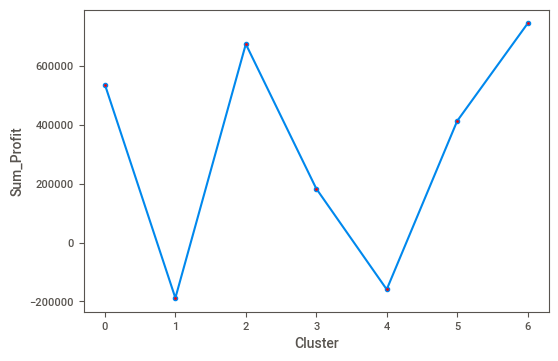

In [149]:
plt.plot(result_df["Cluster"], result_df["Sum_Profit"], marker='o', markerfacecolor='r')
plt.xlabel('Cluster')
plt.ylabel('Sum_Profit')
plt.show()

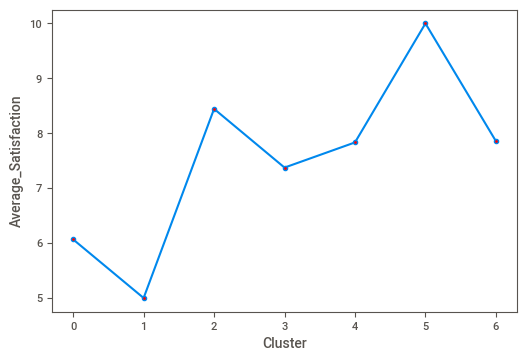

In [148]:
plt.plot(result_df["Cluster"], result_df["Average_Satisfaction"], marker='o', markerfacecolor='r')
plt.xlabel('Cluster')
plt.ylabel('Average_Satisfaction')
plt.show()

### Итоговое сравнение

#### До оптимизации

In [146]:
print("Выручка сети: %.2f  " % Moscow_df["Revenue"].sum())
print("Прибыль сети: %.2f " % Moscow_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % Moscow_df["Satisfaction"].mean())

Выручка сети: 14608219.00  
Прибыль сети: 2206307.00 
Средняя удовлетворенность клиента: 7.42 


#### После оптимизации

In [147]:
after_optimisation_df = Moscow_df.loc[Moscow_df["cluster"] != 1]

print("Выручка сети: %.2f " % after_optimisation_df["Revenue"].sum())
print("Прибыль сети: %.2f " % after_optimisation_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % after_optimisation_df["Satisfaction"].mean())

Выручка сети: 13989302.00 
Прибыль сети: 2394740.00 
Средняя удовлетворенность клиента: 7.56 


Вывод: после закрытия кофеен из кластера 1, у которого самые низкие показатели суммарной прибыли и удовлетворенности клиентов, прибыль сети и средняя удовлетворенность клиента в сети возрастет.

### Оптимизация сети по всей России

In [150]:
df.loc[df['Country'] == 'RU']

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction
Store Number,,,,,,,,,,,,
21293-210647,Starbucks,21293-210647,Joint Venture,"Krasnaya Street, 68",Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,155205,153981,Dissatisfied
24243-236919,Starbucks,24243-236919,Joint Venture,Krasnaya Street 108,Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,163936,141534,Dissatisfied
21292-210645,Starbucks,21292-210645,Joint Venture,"Novaya Zarya Street, 7 Sochi, Krasnodarskiy Kr...",Sochi,RU,GMT+3:00 Europe/Moscow,39.73,43.60,156754,209458,Neither
47794-259744,Starbucks,47794-259744,Joint Venture,"Khimki, IKEA district, bld 2",Khimki,RU,GMT+3:00 Europe/Moscow,37.40,55.91,197601,155445,Very_dissatisfied
32258-119146,Starbucks,32258-119146,Joint Venture,1st Pokrovskiy proezd 5,Kotelniki,RU,GMT+3:00 Europe/Moscow,37.62,55.76,244448,209231,Satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...
24185-236467,Starbucks,24185-236467,Joint Venture,Bahchivandji Square 1,Ekaterinburg,RU,GMT+5:00 Asia/Yekaterinburg,60.80,56.75,192731,157047,Satisfied
23555-231184,Starbucks,23555-231184,Joint Venture,"8 Marta street, 46",Yekaterinburg,RU,GMT+5:00 Asia/Yekaterinburg,60.60,56.83,196475,147601,Satisfied
24026-235125,Starbucks,24026-235125,Joint Venture,D. Mendeleeva Street 1a,Tyumen,RU,GMT+5:00 Asia/Yekaterinburg,65.55,57.12,219643,185303,Satisfied


In [56]:
russia_df = df.loc[df['Country'] == 'RU']
russia_df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction
Store Number,,,,,,,,,,,,
21293-210647,Starbucks,21293-210647,Joint Venture,"Krasnaya Street, 68",Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,192439,130549,Satisfied
24243-236919,Starbucks,24243-236919,Joint Venture,Krasnaya Street 108,Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,241659,146064,Very_satisfied
21292-210645,Starbucks,21292-210645,Joint Venture,"Novaya Zarya Street, 7 Sochi, Krasnodarskiy Kr...",Sochi,RU,GMT+3:00 Europe/Moscow,39.73,43.60,167340,176245,Satisfied


In [151]:
country = "Russia"

locator = geopy.geocoders.Nominatim(user_agent="Russia")
location = locator.geocode(country)
location = [location.latitude, location.longitude]
location

[64.6863136, 97.7453061]

In [152]:
russia_map = folium.Map(location=location, zoom_start=3)

In [59]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
russia_df["size"] = scaler.fit_transform(russia_df["Revenue"].values.reshape(-1,1)).reshape(-1)

for index, row in russia_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    
    if row["Revenue"] < row["Cost"]:
        current_color = "red"
    else:
        current_color = "green"
        
    
    folium.CircleMarker(location=current_location, fill=True, color = current_color , radius = row['size'] ).add_to(russia_map)

In [60]:
russia_map

In [61]:
russia_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 21293-210647 to 20260-204424
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           109 non-null    object 
 1   Store Number    109 non-null    object 
 2   Ownership Type  109 non-null    object 
 3   Street Address  109 non-null    object 
 4   City            109 non-null    object 
 5   Country         109 non-null    object 
 6   Timezone        109 non-null    object 
 7   Longitude       109 non-null    float64
 8   Latitude        109 non-null    float64
 9   Revenue         109 non-null    int64  
 10  Cost            109 non-null    int64  
 11  Satisfaction    109 non-null    object 
 12  size            109 non-null    float64
dtypes: float64(3), int64(2), object(8)
memory usage: 11.9+ KB


In [62]:
set(russia_df['Satisfaction'])

{'Dissatisfied', 'Neither', 'Satisfied', 'Very_dissatisfied', 'Very_satisfied'}

In [63]:
russia_df['Satisfaction'] = russia_df['Satisfaction'].map({'Dissatisfied':2, 'Neither':4, 'Satisfied':6, 'Very_dissatisfied':1, 'Very_satisfied':10})
russia_df.head(2)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction,size
Store Number,,,,,,,,,,,,,
21293-210647,Starbucks,21293-210647,Joint Venture,"Krasnaya Street, 68",Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,192439,130549,6,8.072604
24243-236919,Starbucks,24243-236919,Joint Venture,Krasnaya Street 108,Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,241659,146064,10,13.996480


In [64]:
russia_df['Profit'] = russia_df['Revenue'] - russia_df['Cost'] #создание дополнительного признака

### Кластеризация по России

In [65]:
X = russia_df[['Satisfaction', 'Profit']]
max_k = 10

distortions = []
for i in range(1, (max_k + 1)):
    if len(X)>= i:
        model = KMeans(n_clusters=i, max_iter=300, n_init=10)
        model.fit(X)
        distortions.append(model.inertia_)
distortions

[217266938469.41293,
 66098004347.69825,
 28901700707.960236,
 15461676013.1412,
 9045512477.669146,
 6728926084.11451,
 5063078122.344651,
 3487999811.760404,
 2512286032.855051,
 2059059291.7454135]

In [66]:
k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions, 2)]))
k #оптимальное число кластеров

5

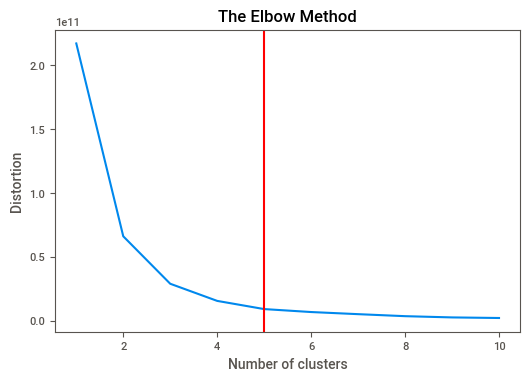

In [67]:
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='-', color='red', label='k = '+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel='Distortion')

plt.show()

In [153]:
k = 5
model = KMeans(n_clusters=k)

X = russia_df[['Satisfaction', 'Profit']]
russia_df['cluster'] = model.fit_predict(X)

russia_df.head(3)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction,size,Profit,cluster
Store Number,,,,,,,,,,,,,,,
21293-210647,Starbucks,21293-210647,Joint Venture,"Krasnaya Street, 68",Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,192439,130549,6,8.072604,61890,4
24243-236919,Starbucks,24243-236919,Joint Venture,Krasnaya Street 108,Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,241659,146064,10,13.996480,95595,0
21292-210645,Starbucks,21292-210645,Joint Venture,"Novaya Zarya Street, 7 Sochi, Krasnodarskiy Kr...",Sochi,RU,GMT+3:00 Europe/Moscow,39.73,43.60,167340,176245,6,5.051813,-8905,3


In [154]:
new_russia_map = folium.Map(location=location, zoom_start=3)

In [156]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
russia_df['size'] = scaler.fit_transform(russia_df['Revenue'].values.reshape(-1,1)).reshape(-1)
color_dict = {0: 'green', 1: "red", 2:"orange", 3:"blue", 4: "yellow", 5:"black", 6:"grey"}

for index, row in russia_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    current_color = color_dict[row['cluster']]
    folium.CircleMarker(location=current_location, fill=True, color=current_color, radius= row['size']).add_to(new_russia_map)

In [157]:
new_russia_map

In [158]:
columns=['Cluster', 'Average_Revenue', 'Sum_Revenue', 'Average_Profit', 'Sum_Profit', 'Average_Satisfaction']

In [159]:
result_russia_df = pd.DataFrame(columns=columns)
result_russia_df

,Cluster,Average_Revenue,Sum_Revenue,Average_Profit,Sum_Profit,Average_Satisfaction


In [160]:
set(russia_df['cluster'])

{0, 1, 2, 3, 4}

In [161]:
russia_df.loc[russia_df['cluster'] == 0].head(2)

,Brand,Store Number,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Revenue,Cost,Satisfaction,size,Profit,cluster
Store Number,,,,,,,,,,,,,,,
24243-236919,Starbucks,24243-236919,Joint Venture,Krasnaya Street 108,Krasnodar,RU,GMT+3:00 Europe/Moscow,38.97,45.03,241659,146064,10,13.996480,95595,0
47794-259744,Starbucks,47794-259744,Joint Venture,"Khimki, IKEA district, bld 2",Khimki,RU,GMT+3:00 Europe/Moscow,37.40,55.91,239290,124320,10,13.711359,114970,0


In [162]:
for i in set(russia_df['cluster']):
    cluster_df = russia_df.loc[russia_df['cluster'] == i]
    result_russia_df.loc[i] = [i, cluster_df['Revenue'].mean(), cluster_df['Revenue'].sum(), cluster_df['Profit'].mean(), cluster_df['Profit'].sum(), cluster_df['Satisfaction'].mean()]
    
result_russia_df

,Cluster,Average_Revenue,Sum_Revenue,Average_Profit,Sum_Profit,Average_Satisfaction
0,0.0,239019.125000,3824306.0,104668.875000,1674702.0,6.562500
1,1.0,191196.482759,5544698.0,28878.448276,837475.0,6.758621
2,2.0,160397.400000,2405961.0,-35624.066667,-534361.0,6.200000
3,3.0,184072.434783,4233666.0,-2361.652174,-54318.0,6.652174
4,4.0,219191.615385,5698982.0,64712.346154,1682521.0,7.076923


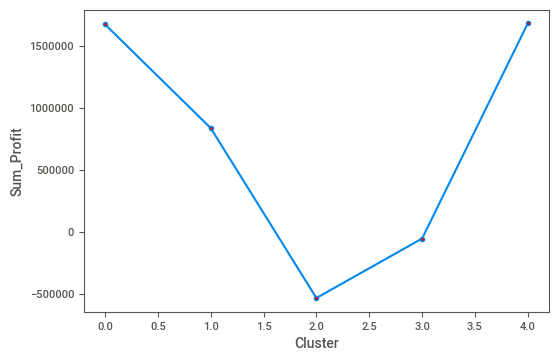

In [163]:
plt.plot(result_russia_df['Cluster'], result_russia_df['Sum_Profit'], marker='o', markerfacecolor='r')
plt.xlabel('Cluster')
plt.ylabel('Sum_Profit')

plt.show()

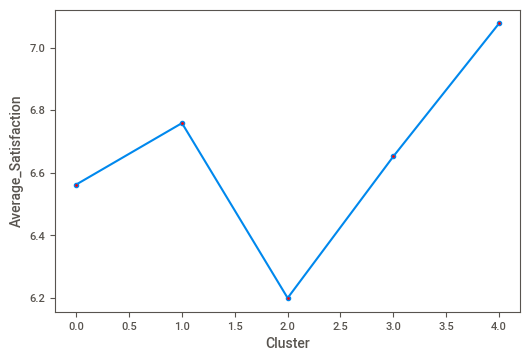

In [164]:
plt.plot(result_russia_df['Cluster'], result_russia_df['Average_Satisfaction'], marker='o', markerfacecolor='r')
plt.xlabel('Cluster')
plt.ylabel('Average_Satisfaction')

plt.show()

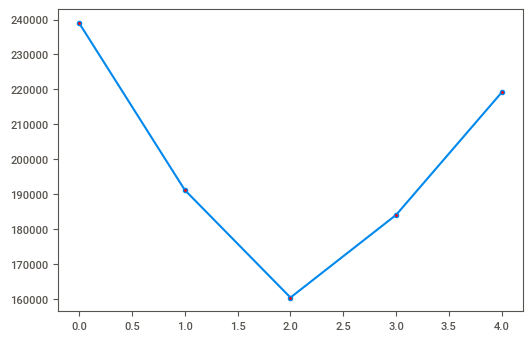

In [165]:
plt.plot(result_russia_df['Cluster'], result_russia_df['Average_Revenue'], marker='o', markerfacecolor='r')
plt.show()

### Выводы по России

До оптимизации:

In [166]:
print('Выручка сети: %.2f ' % russia_df['Revenue'].sum())
print('Прибыль сети: %.2f ' %russia_df['Profit'].sum())
print('Средняя удовлетворенность клиента: %.2f' %russia_df['Satisfaction'].mean())

Выручка сети: 21707613.00 
Прибыль сети: 3606019.00 
Средняя удовлетворенность клиента: 6.71


После оптимизации:

In [167]:
after_optimisation_df = russia_df.loc[russia_df["cluster"] != 2]

print("Выручка сети: %.2f " % after_optimisation_df["Revenue"].sum())
print("Прибыль сети: %.2f " % after_optimisation_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % after_optimisation_df["Satisfaction"].mean())

Выручка сети: 19301652.00 
Прибыль сети: 4140380.00 
Средняя удовлетворенность клиента: 6.79 


При закрытии кофеен из кластера 2 увеличится средняя удовлетворенность клиентов и показатели прибыли. 